In [1]:
%matplotlib notebook

import h5py
from numpy import *
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools

In [2]:
# open hdf5 file
h5file = h5py.File("results.hdf5",mode = "r+")

#iterations, measurements boilerplate
measurements = h5file['settings/experiment/measurementsPerIteration'][()]
iterations = len(h5file['/iterations/'].items())

iVars = []
if iterations > 1:
    for i in h5file['settings/experiment/independentVariables/'].iteritems(): 
        tmp=eval(i[1]['function'][()])
        if (type(tmp) == list) | (type(tmp) == ndarray) | (type(tmp) == tuple): 
            #print i
            iVars.append((i[0],i[1]['function'][()],i[1]['description'][()]))
    iVarVals = list(itertools.product(*[eval(iVars[i][1]) for i in range(len(iVars))]))

    ivs = array(list(itertools.product(*[eval(iVars[i][1]) for i in range(len(iVars))])))
    #print ivs
    #ivs = array(iVarVals[:])[:,0]
else :
    ivs = array([0])

In [3]:
# Get image roi dimensions
roi_size = list(h5file[
    "/settings/experiment/Andors/motors/motor0/camera/subimage_size"
][()])
roi_size.reverse()

#load andor data to numpy array
im_shape = tuple([iterations,measurements]+list(roi_size))
images = zeros(im_shape,dtype=int)
# loop over iterations and load images into numpy array
andor_image_path = "/iterations/{}/measurements/{}/data/Andor_1026/shots/0"
for iteration in range(iterations):
    for measurement in range(measurements):
        images[iteration,measurement,:,:] = h5file[
            andor_image_path.format(iteration,measurement)
        ][()]
    
# Average over measurements
avg_images = images.mean(1)

<IPython.core.display.Javascript object>


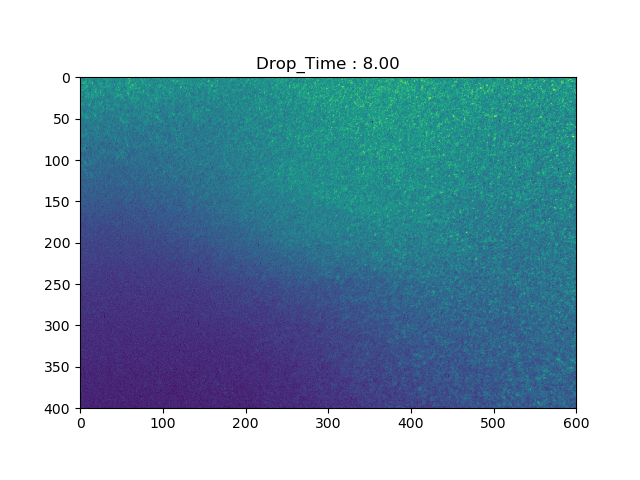

In [4]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(avg_images[0],interpolation='none')

def init():
    im.set_data(avg_images[0])
    return [im]

def animate(i):
    im.set_data(avg_images[i])
    ax.set_title("{} : {:.2f}".format(iVars[0][0],ivs[i][0]))
    return im

anim = animation.FuncAnimation(fig,animate,init_func=init, frames=iterations, interval=200,blit=True)

plt.show()

In [7]:
import matplotlib
matplotlib.matplotlib_fname()

'c:\\users\\hybrid\\envs\\analysis2\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc'

In [5]:
anim.save("MOT_Drop_2020_09_14.gif",writer='imagemagick',fps=4)

In [ ]:
for i in h5file['settings/experiment/independentVariables/'].iteritems():
    print (i[0], i[1]['function'].value, i[1]['description'].value)

In [ ]:
import datetime
import shutil
import re
import os
import operator
from numpy import sort

volume = os.getcwd()[0]
analysis_fname = 'analysis.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# find latest day folder created by cspy
daily_folders = filter(
    dir_filter,
    [os.path.join(measurement_path,f) for f in os.listdir(measurement_path)]
)  # make sure non-folder names are not listed
today_path = sort(daily_folders)[-1]

#find all experiments taken on the last day
experiments_today = filter(
    dir_filter,
    [os.path.join(today_path,f) for f in os.listdir(today_path)]
)
#and the last experiment taken the last day
last_experiment = sort(experiments_today)[-1]
exp_path = os.path.join(today_path, last_experiment)

# Copy
if analysis_fname not in os.listdir(exp_path) or override:
    print("Copying {} from :\n\t{}\nto:\n\t{}".format(analysis_fname,os.getcwd(),exp_path))
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),exp_path)
else:
    print("Folder {} already have analysis file. If you wish to overwrite that file set 'override' to True".format(exp_path))